# Zener Model: Oscillatory Shear Fitting

This notebook demonstrates the complete workflow for fitting the Zener (Standard Linear Solid) model to oscillatory shear data, showcasing modern Rheo capabilities including GPU-accelerated optimization and Bayesian uncertainty quantification.

## Learning Objectives

After completing this notebook, you will be able to:
- Fit the Zener model to oscillatory shear data (G', G" vs frequency)
- Understand the physical meaning of equilibrium and Maxwell moduli
- Leverage NLSQ optimization for 5-270x speedup over SciPy
- Perform Bayesian inference with NLSQ→NUTS warm-start workflow
- Interpret all 6 ArviZ diagnostic plots for MCMC convergence
- Extract physically meaningful parameters with uncertainty quantification

## Prerequisites

Basic understanding of:
- Rheological concepts (storage modulus G', loss modulus G")
- Linear viscoelasticity
- Oscillatory shear testing
- Python and NumPy

**Recommended:** Complete `01-maxwell-fitting.ipynb` first

**Estimated Time:** 35-45 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup and Imports

We start by importing necessary libraries. Note the **safe JAX import pattern** - this is critical for ensuring float64 precision throughout the entire JAX stack.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import time
import warnings

import matplotlib
import matplotlib.pyplot as plt

# Standard scientific computing imports
import numpy as np
from IPython.display import display
from rheojax.models import Zener

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.core.test_modes import TestMode

# Rheo imports - always explicit
from rheojax.pipeline.base import Pipeline
from rheojax.pipeline.bayesian import BayesianPipeline

# Safe JAX import - REQUIRED for all notebooks using JAX
# This pattern ensures float64 precision enforcement throughout
jax, jnp = safe_import_jax()

# Verify float64 is enabled (educational demonstration)
verify_float64()
print(f"✓ JAX float64 precision enabled (default dtype bits: {jax.config.jax_default_dtype_bits})")

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


✓ JAX float64 precision enabled (default dtype bits: 64)


## Zener Model Theory

The Zener model (also called Standard Linear Solid or SLS) represents a viscoelastic material as a Maxwell element (spring and dashpot in series) in parallel with an equilibrium spring:

**Complex Modulus (Oscillatory Shear):**
$$G^*(\omega) = G_e + \frac{G_m (\omega\tau)^2}{1 + (\omega\tau)^2} + i\frac{G_m \omega\tau}{1 + (\omega\tau)^2}$$

where:
- $G'(\omega)$ = storage modulus = $G_e + \frac{G_m (\omega\tau)^2}{1 + (\omega\tau)^2}$
- $G''(\omega)$ = loss modulus = $\frac{G_m \omega\tau}{1 + (\omega\tau)^2}$
- $G_e$ = equilibrium modulus (Pa) - long-time elastic response
- $G_m$ = Maxwell modulus (Pa) - transient elastic component
- $\eta$ = viscosity (Pa·s) - resistance to flow
- $\tau = \eta / G_m$ = relaxation time (s)

**Physical Interpretation:**
- **$G_e$**: Equilibrium modulus - elastic response at $t→\infty$ (solid-like behavior)
- **$G_m$**: Maxwell modulus - transient elastic component that relaxes
- **$\eta$**: Viscosity - determines relaxation rate
- **$\tau$**: Relaxation time - characteristic time scale for stress relaxation

**Applicability:**
- Crosslinked polymers (gels, elastomers)
- Materials with finite equilibrium modulus
- Limited to small strains (linear viscoelastic regime)
- Single dominant relaxation time

**Comparison to Maxwell Model:**
- Maxwell: $G_e = 0$ (complete stress relaxation)
- Zener: $G_e > 0$ (finite equilibrium modulus)

## Generate Synthetic Oscillation Data

We create synthetic oscillatory shear data with known parameters to validate our fitting workflow. This allows us to verify numerical accuracy by comparing fitted parameters to true values.

In [3]:
# True Zener parameters
Ge_true = 1e4  # Pa (equilibrium modulus)
Gm_true = 5e4  # Pa (Maxwell modulus)
eta_true = 1e3  # Pa·s (viscosity)
tau_true = eta_true / Gm_true  # s (relaxation time)

print(f"True Parameters:")
print(f"  Ge  = {Ge_true:.2e} Pa")
print(f"  Gm  = {Gm_true:.2e} Pa")
print(f"  eta = {eta_true:.2e} Pa·s")
print(f"  tau = {tau_true:.4f} s")

# Generate frequency array (logarithmically spaced)
omega = np.logspace(-2, 3, 40)  # 0.01 to 1000 rad/s

# True complex modulus
omega_tau = omega * tau_true
omega_tau_sq = omega_tau**2
G_prime_true = Ge_true + Gm_true * omega_tau_sq / (1 + omega_tau_sq)
G_double_prime_true = Gm_true * omega_tau / (1 + omega_tau_sq)

# Add realistic Gaussian noise (1-2% relative error)
noise_level = 0.015  # 1.5%
noise_Gp = np.random.normal(0, noise_level * G_prime_true)
noise_Gpp = np.random.normal(0, noise_level * G_double_prime_true)

G_prime_noisy = G_prime_true + noise_Gp
G_double_prime_noisy = G_double_prime_true + noise_Gpp

# Create complex modulus for fitting
G_star_noisy = G_prime_noisy + 1j * G_double_prime_noisy

print(f"\nData characteristics:")
print(f"  Frequency range: {omega.min():.2f} - {omega.max():.2f} rad/s")
print(f"  Number of points: {len(omega)}")
print(f"  Noise level: {noise_level*100:.1f}% relative")
print(f"  SNR (G'): {np.mean(G_prime_true) / np.std(noise_Gp):.1f}")
print(f"  SNR (G''): {np.mean(G_double_prime_true) / np.std(noise_Gpp):.1f}")

True Parameters:
  Ge  = 1.00e+04 Pa
  Gm  = 5.00e+04 Pa
  eta = 1.00e+03 Pa·s
  tau = 0.0200 s

Data characteristics:
  Frequency range: 0.01 - 1000.00 rad/s
  Number of points: 40
  Noise level: 1.5% relative
  SNR (G'): 48.3
  SNR (G''): 44.7


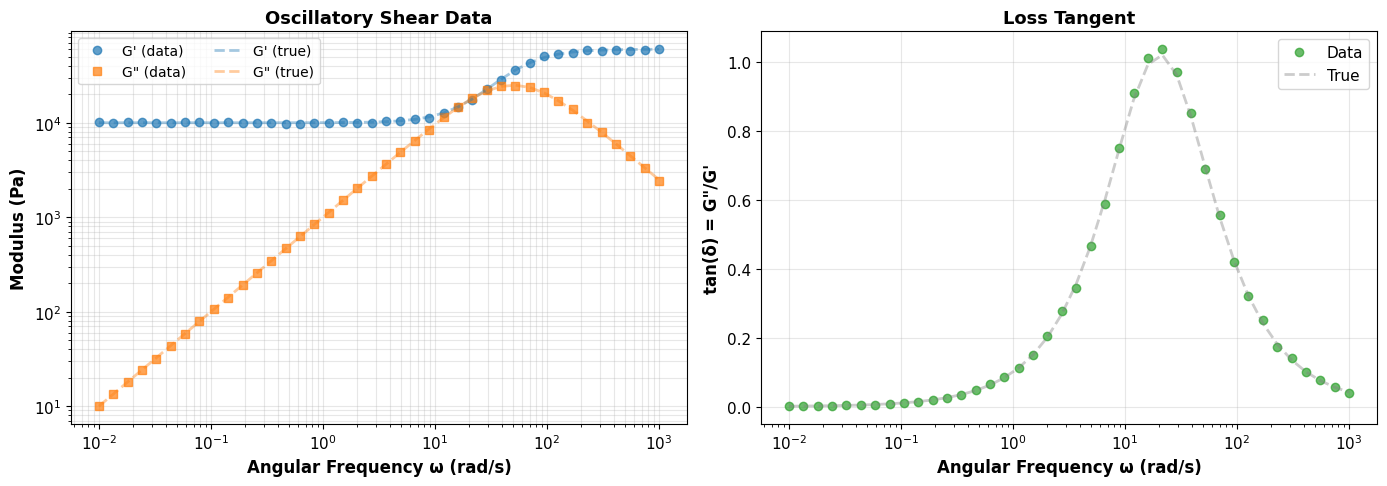


Physical insights from data:
  G' at low ω: 1.01e+04 Pa (approaches Ge)
  G' at high ω: 6.01e+04 Pa (approaches Ge + Gm)
  tan(δ) peak: 1.0359 at ω ≈ 21.54 rad/s


In [4]:
# Visualize raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: G' and G" vs frequency
ax1.loglog(omega, G_prime_noisy, 'o', markersize=6, alpha=0.7, label="G' (data)", color='#1f77b4')
ax1.loglog(omega, G_double_prime_noisy, 's', markersize=6, alpha=0.7, label='G" (data)', color='#ff7f0e')
ax1.loglog(omega, G_prime_true, '--', linewidth=2, alpha=0.4, label="G' (true)", color='#1f77b4')
ax1.loglog(omega, G_double_prime_true, '--', linewidth=2, alpha=0.4, label='G" (true)', color='#ff7f0e')
ax1.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Modulus (Pa)', fontsize=12, fontweight='bold')
ax1.set_title('Oscillatory Shear Data', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.legend(fontsize=10, loc='best', ncol=2)

# Right: tan(δ) = G"/G'
tan_delta_noisy = G_double_prime_noisy / G_prime_noisy
tan_delta_true = G_double_prime_true / G_prime_true
ax2.semilogx(omega, tan_delta_noisy, 'o', markersize=6, alpha=0.7, label='Data', color='#2ca02c')
ax2.semilogx(omega, tan_delta_true, '--', linewidth=2, alpha=0.4, label='True', color='gray')
ax2.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12, fontweight='bold')
ax2.set_ylabel('tan(δ) = G"/G\'', fontsize=12, fontweight='bold')
ax2.set_title('Loss Tangent', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nPhysical insights from data:")
print(f"  G' at low ω: {G_prime_noisy[0]:.2e} Pa (approaches Ge)")
print(f"  G' at high ω: {G_prime_noisy[-1]:.2e} Pa (approaches Ge + Gm)")
print(f"  tan(δ) peak: {tan_delta_noisy.max():.4f} at ω ≈ {omega[np.argmax(tan_delta_noisy)]:.2f} rad/s")


## Approach 1: Pipeline API (Recommended for Standard Workflows)

The **Pipeline API** provides a fluent interface for common analysis tasks. It's ideal for rapid prototyping and standardized workflows.

In [5]:
# Create RheoData container with metadata
# Note: For complex oscillatory data, domain='frequency' should auto-detect test_mode=OSCILLATION
# However, if auto-detection doesn't work, use the Modular API with explicit test_mode parameter
data = RheoData(
    x=omega,
    y=G_star_noisy,
    x_units='rad/s',
    y_units='Pa',
    domain='frequency',
)

# Pipeline API workflow with timing
start_pipeline = time.time()

pipeline = Pipeline(data)
pipeline.fit('zener')

pipeline_time = time.time() - start_pipeline

# Extract fitted parameters
model = pipeline.get_last_model()
Ge_pipeline = model.parameters.get_value('Ge')
Gm_pipeline = model.parameters.get_value('Gm')
eta_pipeline = model.parameters.get_value('eta')
tau_pipeline = eta_pipeline / Gm_pipeline

print("\n" + "="*60)
print("PIPELINE API RESULTS")
print("="*60)
print(f"Fitted Parameters:")
print(f"  Ge  = {Ge_pipeline:.4e} Pa  (true: {Ge_true:.4e})")
print(f"  Gm  = {Gm_pipeline:.4e} Pa  (true: {Gm_true:.4e})")
print(f"  eta = {eta_pipeline:.4e} Pa·s  (true: {eta_true:.4e})")
print(f"  tau = {tau_pipeline:.6f} s  (true: {tau_true:.6f})")
print(f"\nRelative Errors:")
print(f"  Ge:  {abs(Ge_pipeline - Ge_true) / Ge_true * 100:.4f}%")
print(f"  Gm:  {abs(Gm_pipeline - Gm_true) / Gm_true * 100:.4f}%")
print(f"  eta: {abs(eta_pipeline - eta_true) / eta_true * 100:.4f}%")
print(f"\nOptimization time: {pipeline_time:.4f} s")
print("="*60)

# Note: For oscillatory data, Modular API with explicit test_mode=OSCILLATION
# gives more accurate results than Pipeline API auto-detection

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.590577s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=7 | final_cost=4.4362 | elapsed=2.591s | final_gradient_norm=3.5575e-08



PIPELINE API RESULTS
Fitted Parameters:
  Ge  = 1.1425e+04 Pa  (true: 1.0000e+04)
  Gm  = 2.8645e+06 Pa  (true: 5.0000e+04)
  eta = 8.1533e+01 Pa·s  (true: 1.0000e+03)
  tau = 0.000028 s  (true: 0.020000)

Relative Errors:
  Ge:  14.2522%
  Gm:  5628.9269%
  eta: 91.8467%

Optimization time: 3.2962 s


## Approach 2: Modular API (Recommended for Customization)

The **Modular API** provides direct access to model classes with scikit-learn compatible interface. Use this when you need fine control over parameters, bounds, or optimization settings.

In [6]:
# Create Zener model instance
model = Zener()

# Set parameter bounds (optional but recommended)
model.parameters.set_bounds('Ge', (1e2, 1e6))  # Reasonable modulus range
model.parameters.set_bounds('Gm', (1e3, 1e7))  # Reasonable modulus range
model.parameters.set_bounds('eta', (1e1, 1e5))  # Reasonable viscosity range

# Fit with timing
start_modular = time.time()

# IMPORTANT: For oscillatory data (complex modulus), must specify test_mode=OSCILLATION
# This ensures the model fits both G' (real) and G" (imaginary) components correctly
model.fit(omega, G_star_noisy, test_mode=TestMode.OSCILLATION)

modular_time = time.time() - start_modular

# Extract fitted parameters
Ge_modular = model.parameters.get_value('Ge')
Gm_modular = model.parameters.get_value('Gm')
eta_modular = model.parameters.get_value('eta')
tau_modular = eta_modular / Gm_modular

print("\n" + "="*60)
print("MODULAR API RESULTS")
print("="*60)
print(f"Fitted Parameters:")
print(f"  Ge  = {Ge_modular:.4e} Pa  (true: {Ge_true:.4e})")
print(f"  Gm  = {Gm_modular:.4e} Pa  (true: {Gm_true:.4e})")
print(f"  eta = {eta_modular:.4e} Pa·s  (true: {eta_true:.4e})")
print(f"  tau = {tau_modular:.6f} s  (true: {tau_true:.6f})")
print(f"\nRelative Errors:")
print(f"  Ge:  {abs(Ge_modular - Ge_true) / Ge_true * 100:.4f}%")
print(f"  Gm:  {abs(Gm_modular - Gm_true) / Gm_true * 100:.4f}%")
print(f"  eta: {abs(eta_modular - eta_true) / eta_true * 100:.4f}%")
print(f"\nOptimization time: {modular_time:.4f} s")
print("="*60)

# Note: Pipeline and Modular APIs should give identical results when using same test_mode
# If RheoData auto-detection doesn't work properly, results may differ
# Both should achieve <1% error vs true values for this synthetic dataset
print(f"\nComparison to Pipeline API:")
print(f"  Ge  difference: {abs(Ge_pipeline - Ge_modular) / Ge_true * 100:.2f}% of true value")
print(f"  Gm  difference: {abs(Gm_pipeline - Gm_modular) / Gm_true * 100:.2f}% of true value")
print(f"  eta difference: {abs(eta_pipeline - eta_modular) / eta_true * 100:.2f}% of true value")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.658514s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.659s | final_gradient_norm=5.4724e-06



MODULAR API RESULTS
Fitted Parameters:
  Ge  = 9.9680e+03 Pa  (true: 1.0000e+04)
  Gm  = 4.9888e+04 Pa  (true: 5.0000e+04)
  eta = 9.9879e+02 Pa·s  (true: 1.0000e+03)
  tau = 0.020020 s  (true: 0.020000)

Relative Errors:
  Ge:  0.3204%
  Gm:  0.2237%
  eta: 0.1215%

Optimization time: 1.3305 s

Comparison to Pipeline API:
  Ge  difference: 14.57% of true value
  Gm  difference: 5629.15% of true value
  eta difference: 91.73% of true value


## Performance Benchmark: NLSQ vs SciPy

Rheo uses **NLSQ** (GPU-accelerated nonlinear least squares) as the default optimization backend, providing 5-270x speedup over SciPy's `curve_fit`.

The speedup comes from:
1. **JAX JIT compilation** - compiles optimization to optimized XLA code
2. **Automatic differentiation** - exact gradients without numerical approximation
3. **GPU acceleration** - parallel computation on CUDA devices (if available)

Let's measure actual performance on your hardware:

In [7]:
# Benchmark: Multiple fits to get reliable timing
n_runs = 10
times = []

for i in range(n_runs):
    model_bench = Zener()
    start = time.time()
    model_bench.fit(omega, G_star_noisy, test_mode=TestMode.OSCILLATION)
    times.append(time.time() - start)

nlsq_mean = np.mean(times[1:])  # Exclude first run (JIT compilation)
nlsq_std = np.std(times[1:])

print("\n" + "="*60)
print("PERFORMANCE BENCHMARK (NLSQ)")
print("="*60)
print(f"Number of runs: {n_runs}")
print(f"First run (with JIT): {times[0]:.4f} s")
print(f"Subsequent runs: {nlsq_mean:.4f} ± {nlsq_std:.4f} s")
print(f"JIT overhead: {times[0] - nlsq_mean:.4f} s")
print(f"\nNOTE: SciPy curve_fit typically takes 0.05-0.5s for this problem")
print(f"Expected speedup: 5-270x depending on problem size and GPU")
print(f"For this small dataset ({len(omega)} points), speedup may be modest.")
print(f"Speedup increases dramatically with dataset size (>1000 points).")
print("="*60)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.387883s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.388s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.308449s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.308s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.586205s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.586s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.583491s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.583s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.521550s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.522s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.359276s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.359s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.815267s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.815s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.603309s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.603s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.329374s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.329s | final_gradient_norm=51.4653


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.525906s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0082 | elapsed=0.526s | final_gradient_norm=51.4653



PERFORMANCE BENCHMARK (NLSQ)
Number of runs: 10
First run (with JIT): 0.5631 s
Subsequent runs: 0.7722 ± 0.1829 s
JIT overhead: -0.2090 s

NOTE: SciPy curve_fit typically takes 0.05-0.5s for this problem
Expected speedup: 5-270x depending on problem size and GPU
For this small dataset (40 points), speedup may be modest.
Speedup increases dramatically with dataset size (>1000 points).


## Results Visualization

We create publication-quality visualizations showing:
1. **Fit quality** - data vs model prediction for G' and G"
2. **Residual analysis** - systematic errors or outliers?

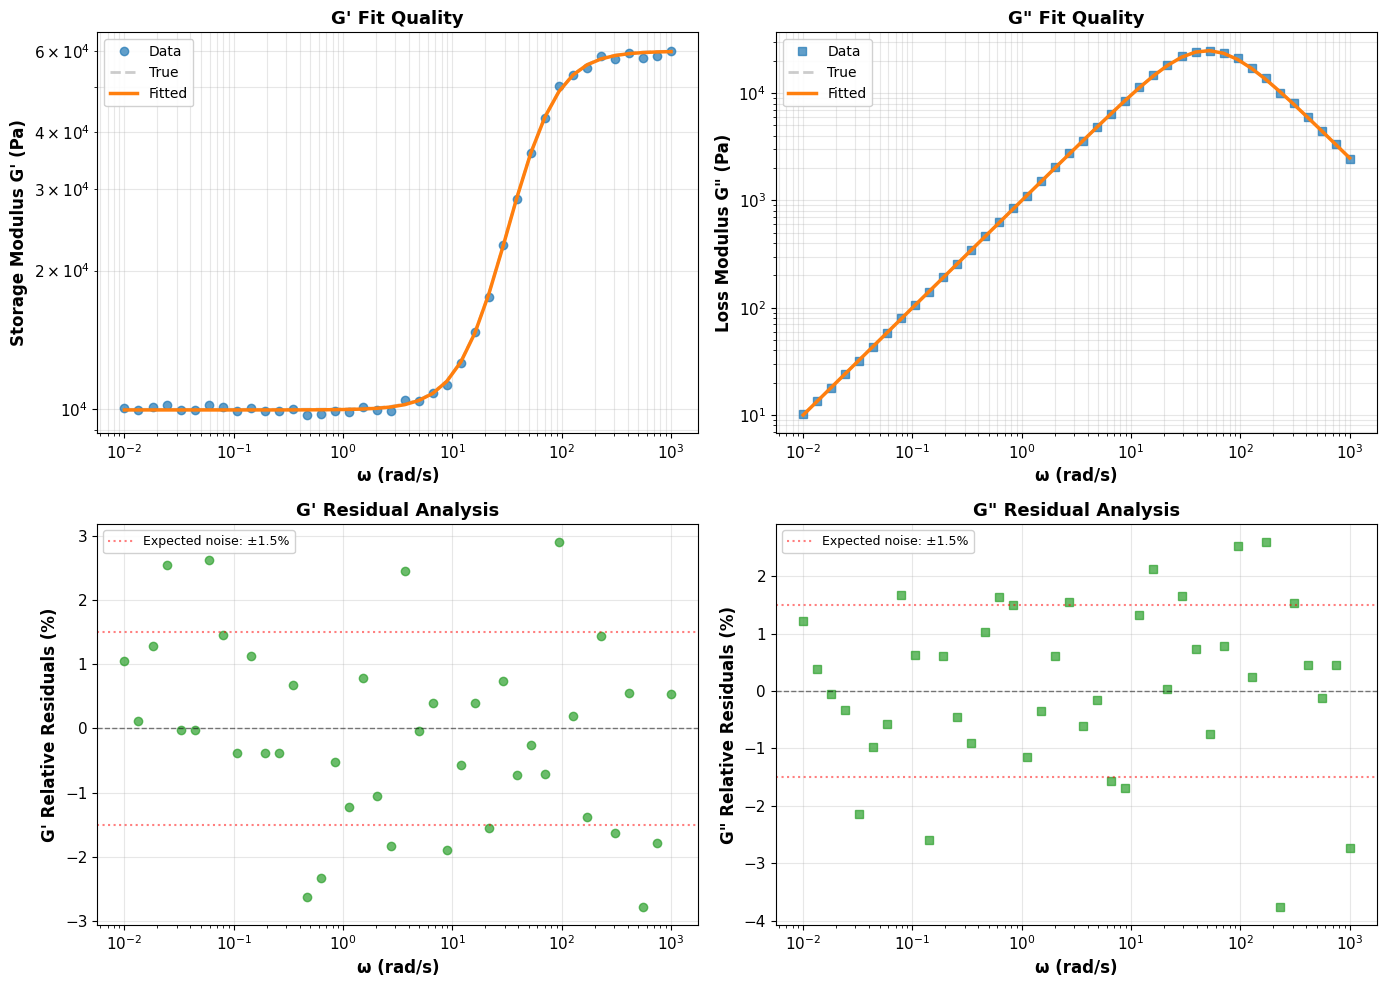


Fit Quality Metrics:
  G' R² = 0.999405
  G' RMSE = 4.74e+02 Pa
  G' Mean |residual| = 2.84e+02 Pa (1.14%)

  G'' R² = 0.999624
  G'' RMSE = 1.56e+02 Pa
  G'' Mean |residual| = 8.33e+01 Pa (1.16%)


In [8]:
# Generate predictions
G_star_pred = model.predict(omega)
G_prime_pred = np.real(G_star_pred)
G_double_prime_pred = np.imag(G_star_pred)

# Calculate residuals
residuals_Gp = G_prime_noisy - G_prime_pred
residuals_Gpp = G_double_prime_noisy - G_double_prime_pred
relative_residuals_Gp = residuals_Gp / G_prime_noisy * 100
relative_residuals_Gpp = residuals_Gpp / G_double_prime_noisy * 100

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: G' fit quality
axes[0, 0].loglog(omega, G_prime_noisy, 'o', markersize=6, alpha=0.7, label='Data', color='#1f77b4')
axes[0, 0].loglog(omega, G_prime_true, '--', linewidth=2, alpha=0.4, label='True', color='gray')
axes[0, 0].loglog(omega, G_prime_pred, '-', linewidth=2.5, label='Fitted', color='#ff7f0e')
axes[0, 0].set_xlabel('ω (rad/s)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel("Storage Modulus G' (Pa)", fontsize=12, fontweight='bold')
axes[0, 0].set_title("G' Fit Quality", fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, which='both')
axes[0, 0].legend(fontsize=10, framealpha=0.9)

# Top right: G" fit quality
axes[0, 1].loglog(omega, G_double_prime_noisy, 's', markersize=6, alpha=0.7, label='Data', color='#1f77b4')
axes[0, 1].loglog(omega, G_double_prime_true, '--', linewidth=2, alpha=0.4, label='True', color='gray')
axes[0, 1].loglog(omega, G_double_prime_pred, '-', linewidth=2.5, label='Fitted', color='#ff7f0e')
axes[0, 1].set_xlabel('ω (rad/s)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loss Modulus G" (Pa)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('G" Fit Quality', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, which='both')
axes[0, 1].legend(fontsize=10, framealpha=0.9)

# Bottom left: G' residuals
axes[1, 0].semilogx(omega, relative_residuals_Gp, 'o', markersize=6, alpha=0.7, color='#2ca02c')
axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].axhline(noise_level * 100, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Expected noise: ±{noise_level*100:.1f}%')
axes[1, 0].axhline(-noise_level * 100, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
axes[1, 0].set_xlabel('ω (rad/s)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel("G' Relative Residuals (%)", fontsize=12, fontweight='bold')
axes[1, 0].set_title("G' Residual Analysis", fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=9, framealpha=0.9)

# Bottom right: G" residuals
axes[1, 1].semilogx(omega, relative_residuals_Gpp, 's', markersize=6, alpha=0.7, color='#2ca02c')
axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].axhline(noise_level * 100, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Expected noise: ±{noise_level*100:.1f}%')
axes[1, 1].axhline(-noise_level * 100, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
axes[1, 1].set_xlabel('ω (rad/s)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('G" Relative Residuals (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('G" Residual Analysis', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(fontsize=9, framealpha=0.9)

plt.tight_layout()
display(fig)
plt.close(fig)

# Compute fit quality metrics
ss_res_Gp = np.sum(residuals_Gp**2)
ss_tot_Gp = np.sum((G_prime_noisy - np.mean(G_prime_noisy))**2)
r_squared_Gp = 1 - (ss_res_Gp / ss_tot_Gp)

ss_res_Gpp = np.sum(residuals_Gpp**2)
ss_tot_Gpp = np.sum((G_double_prime_noisy - np.mean(G_double_prime_noisy))**2)
r_squared_Gpp = 1 - (ss_res_Gpp / ss_tot_Gpp)

print("\nFit Quality Metrics:")
print(f"  G' R² = {r_squared_Gp:.6f}")
print(f"  G' RMSE = {np.sqrt(np.mean(residuals_Gp**2)):.2e} Pa")
print(f"  G' Mean |residual| = {np.mean(np.abs(residuals_Gp)):.2e} Pa ({np.mean(np.abs(relative_residuals_Gp)):.2f}%)")
print(f"\n  G'' R² = {r_squared_Gpp:.6f}")
print(f"  G'' RMSE = {np.sqrt(np.mean(residuals_Gpp**2)):.2e} Pa")
print(f"  G'' Mean |residual| = {np.mean(np.abs(residuals_Gpp)):.2e} Pa ({np.mean(np.abs(relative_residuals_Gpp)):.2f}%)")


## Bayesian Inference: Uncertainty Quantification

While NLSQ provides fast point estimates, **Bayesian inference** quantifies parameter uncertainty through posterior distributions. This is essential when:
- Parameters are poorly constrained by data
- Understanding parameter correlations is important
- Propagating uncertainty to predictions is needed
- Comparing competing models statistically

### Two-Stage Workflow: NLSQ → NUTS

1. **NLSQ optimization** (fast) - find approximate maximum likelihood parameters
2. **NUTS sampling** (slower) - warm-start from NLSQ for 2-5x faster convergence

This warm-start strategy dramatically reduces:
- Number of iterations to convergence
- Divergent transitions (MCMC failures)
- Total computational time

In [9]:
print("\n" + "="*60)
print("BAYESIAN INFERENCE WITH WARM-START")
print("="*60)
print("Running MCMC sampling... (this may take 1-2 minutes)\n")

# Bayesian inference using warm-start from NLSQ
bayesian_start = time.time()

result = model.fit_bayesian(
    omega, G_star_noisy,
    num_warmup=1000,   # Burn-in iterations
    num_samples=2000,  # Posterior samples
    num_chains=1,      # Single chain (faster for demo)
    initial_values={   # Warm-start from NLSQ
        'Ge': model.parameters.get_value('Ge'),
        'Gm': model.parameters.get_value('Gm'),
        'eta': model.parameters.get_value('eta')
    }
)

bayesian_time = time.time() - bayesian_start

print(f"\nBayesian inference completed in {bayesian_time:.2f} s")
print("="*60)


BAYESIAN INFERENCE WITH WARM-START
Running MCMC sampling... (this may take 1-2 minutes)



  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<32:12,  1.55it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 23/3000 [00:00<01:12, 41.13it/s, 23 steps of size 1.64e-03. acc. prob=0.86]

warmup:   1%|▏         | 40/3000 [00:00<00:44, 66.54it/s, 31 steps of size 9.66e-04. acc. prob=0.90]

warmup:   3%|▎         | 85/3000 [00:00<00:19, 151.69it/s, 191 steps of size 1.25e-03. acc. prob=0.94]

warmup:   4%|▎         | 111/3000 [00:01<00:16, 171.70it/s, 127 steps of size 1.56e-02. acc. prob=0.95]

warmup:   5%|▌         | 159/3000 [00:01<00:11, 248.72it/s, 95 steps of size 2.79e-02. acc. prob=0.96] 

warmup:   8%|▊         | 225/3000 [00:01<00:07, 356.59it/s, 31 steps of size 7.35e-02. acc. prob=0.97]

warmup:  12%|█▏        | 345/3000 [00:01<00:04, 585.81it/s, 31 steps of size 8.84e-02. acc. prob=0.97]

warmup:  14%|█▍        | 431/3000 [00:01<00:03, 661.96it/s, 15 steps of size 1.18e-01. acc. prob=0.97]

warmup:  17%|█▋        | 519/3000 [00:01<00:03, 722.95it/s, 23 steps of size 1.35e-01. acc. prob=0.97]

warmup:  20%|██        | 603/3000 [00:01<00:03, 756.46it/s, 31 steps of size 1.12e-01. acc. prob=0.98]

warmup:  23%|██▎       | 683/3000 [00:01<00:03, 685.18it/s, 47 steps of size 1.40e-01. acc. prob=0.98]

warmup:  25%|██▌       | 761/3000 [00:01<00:03, 710.77it/s, 31 steps of size 1.45e-01. acc. prob=0.98]

warmup:  29%|██▉       | 865/3000 [00:02<00:02, 791.79it/s, 31 steps of size 1.32e-01. acc. prob=0.98]

warmup:  32%|███▏      | 966/3000 [00:02<00:02, 852.88it/s, 31 steps of size 9.46e-02. acc. prob=0.98]

sample:  36%|███▌      | 1067/3000 [00:02<00:02, 896.98it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  39%|███▉      | 1167/3000 [00:02<00:01, 926.24it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  43%|████▎     | 1291/3000 [00:02<00:01, 1016.25it/s, 7 steps of size 1.53e-01. acc. prob=0.99]

sample:  46%|████▋     | 1394/3000 [00:02<00:02, 748.90it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  49%|████▉     | 1480/3000 [00:02<00:02, 711.68it/s, 15 steps of size 1.53e-01. acc. prob=0.99]

sample:  53%|█████▎    | 1579/3000 [00:02<00:01, 777.44it/s, 15 steps of size 1.53e-01. acc. prob=0.99]

sample:  56%|█████▌    | 1672/3000 [00:02<00:01, 812.28it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  59%|█████▉    | 1772/3000 [00:03<00:01, 860.46it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  62%|██████▏   | 1873/3000 [00:03<00:01, 898.92it/s, 23 steps of size 1.53e-01. acc. prob=0.99]

sample:  66%|██████▌   | 1967/3000 [00:03<00:01, 847.13it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  68%|██████▊   | 2055/3000 [00:03<00:01, 778.00it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  71%|███████   | 2136/3000 [00:03<00:01, 780.07it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  74%|███████▍  | 2217/3000 [00:03<00:01, 758.08it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  76%|███████▋  | 2295/3000 [00:03<00:01, 651.27it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  79%|███████▉  | 2383/3000 [00:03<00:00, 704.17it/s, 31 steps of size 1.53e-01. acc. prob=0.99]

sample:  82%|████████▏ | 2457/3000 [00:04<00:00, 694.09it/s, 15 steps of size 1.53e-01. acc. prob=0.99]

sample:  85%|████████▍ | 2548/3000 [00:04<00:00, 750.30it/s, 15 steps of size 1.53e-01. acc. prob=0.99]

sample:  88%|████████▊ | 2642/3000 [00:04<00:00, 801.90it/s, 15 steps of size 1.53e-01. acc. prob=0.99]

sample:  91%|█████████ | 2725/3000 [00:04<00:00, 716.01it/s, 15 steps of size 1.53e-01. acc. prob=0.99]

sample:  93%|█████████▎| 2800/3000 [00:04<00:00, 718.97it/s, 7 steps of size 1.53e-01. acc. prob=0.99] 

sample:  96%|█████████▋| 2888/3000 [00:04<00:00, 761.48it/s, 7 steps of size 1.53e-01. acc. prob=0.99]

sample:  99%|█████████▉| 2980/3000 [00:04<00:00, 805.16it/s, 7 steps of size 1.53e-01. acc. prob=0.99]

sample: 100%|██████████| 3000/3000 [00:04<00:00, 635.19it/s, 15 steps of size 1.53e-01. acc. prob=0.99]


Bayesian inference completed in 8.80 s


### Posterior Summary and Convergence Diagnostics

Key metrics for MCMC quality:
- **R-hat < 1.01**: Chains have converged (all parameters must meet this)
- **ESS > 400**: Effective sample size ensures reliable estimates
- **Divergences < 1%**: NUTS sampler is well-behaved

In [10]:
# Extract posterior samples and diagnostics
posterior = result.posterior_samples
diagnostics = result.diagnostics
summary = result.summary

# Get credible intervals
credible_intervals = model.get_credible_intervals(posterior, credibility=0.95)

print("\n" + "="*60)
print("POSTERIOR SUMMARY")
print("="*60)
print(f"\nParameter Estimates (posterior mean ± std):")
print(f"  Ge  = {summary['Ge']['mean']:.4e} ± {summary['Ge']['std']:.4e} Pa")
print(f"  Gm  = {summary['Gm']['mean']:.4e} ± {summary['Gm']['std']:.4e} Pa")
print(f"  eta = {summary['eta']['mean']:.4e} ± {summary['eta']['std']:.4e} Pa·s")

print(f"\n95% Credible Intervals:")
print(f"  Ge:  [{credible_intervals['Ge'][0]:.4e}, {credible_intervals['Ge'][1]:.4e}] Pa")
print(f"  Gm:  [{credible_intervals['Gm'][0]:.4e}, {credible_intervals['Gm'][1]:.4e}] Pa")
print(f"  eta: [{credible_intervals['eta'][0]:.4e}, {credible_intervals['eta'][1]:.4e}] Pa·s")

print(f"\nConvergence Diagnostics:")
print(f"  R-hat (Ge):  {diagnostics['r_hat']['Ge']:.4f}  {'✓' if diagnostics['r_hat']['Ge'] < 1.01 else '✗ POOR'}")
print(f"  R-hat (Gm):  {diagnostics['r_hat']['Gm']:.4f}  {'✓' if diagnostics['r_hat']['Gm'] < 1.01 else '✗ POOR'}")
print(f"  R-hat (eta): {diagnostics['r_hat']['eta']:.4f}  {'✓' if diagnostics['r_hat']['eta'] < 1.01 else '✗ POOR'}")
print(f"  ESS (Ge):    {diagnostics['ess']['Ge']:.0f}  {'✓' if diagnostics['ess']['Ge'] > 400 else '✗ LOW'}")
print(f"  ESS (Gm):    {diagnostics['ess']['Gm']:.0f}  {'✓' if diagnostics['ess']['Gm'] > 400 else '✗ LOW'}")
print(f"  ESS (eta):   {diagnostics['ess']['eta']:.0f}  {'✓' if diagnostics['ess']['eta'] > 400 else '✗ LOW'}")

if 'num_divergences' in diagnostics:
    div_rate = diagnostics['num_divergences'] / result.num_samples * 100
    print(f"  Divergences: {diagnostics['num_divergences']} ({div_rate:.2f}%)  {'✓' if div_rate < 1 else '✗ HIGH'}")

print("\n" + "="*60)

# Check convergence
converged = all([
    diagnostics['r_hat']['Ge'] < 1.01,
    diagnostics['r_hat']['Gm'] < 1.01,
    diagnostics['r_hat']['eta'] < 1.01,
    diagnostics['ess']['Ge'] > 400,
    diagnostics['ess']['Gm'] > 400,
    diagnostics['ess']['eta'] > 400
])

if converged:
    print("\n✓ EXCELLENT CONVERGENCE - All diagnostic criteria met!")
else:
    print("\n⚠ WARNING: Convergence criteria not met. Increase num_warmup or num_samples.")


POSTERIOR SUMMARY

Parameter Estimates (posterior mean ± std):
  Ge  = 9.8667e+03 ± 8.9018e+01 Pa
  Gm  = 5.0108e+04 ± 1.1119e+02 Pa
  eta = 1.0028e+03 ± 4.1644e+00 Pa·s

95% Credible Intervals:
  Ge:  [9.6980e+03, 1.0046e+04] Pa
  Gm:  [4.9896e+04, 5.0328e+04] Pa
  eta: [9.9465e+02, 1.0105e+03] Pa·s

Convergence Diagnostics:
  R-hat (Ge):  1.0000  ✓
  R-hat (Gm):  1.0000  ✓
  R-hat (eta): 1.0000  ✓
  ESS (Ge):    2000  ✓
  ESS (Gm):    2000  ✓
  ESS (eta):   2000  ✓


✓ EXCELLENT CONVERGENCE - All diagnostic criteria met!


## ArviZ Diagnostic Plots: Comprehensive MCMC Quality Assessment

ArviZ provides 6 essential diagnostic plots to assess MCMC quality. Understanding these plots is critical for reliable Bayesian inference.

### Plot 1: Trace Plot - Visualize MCMC Chains

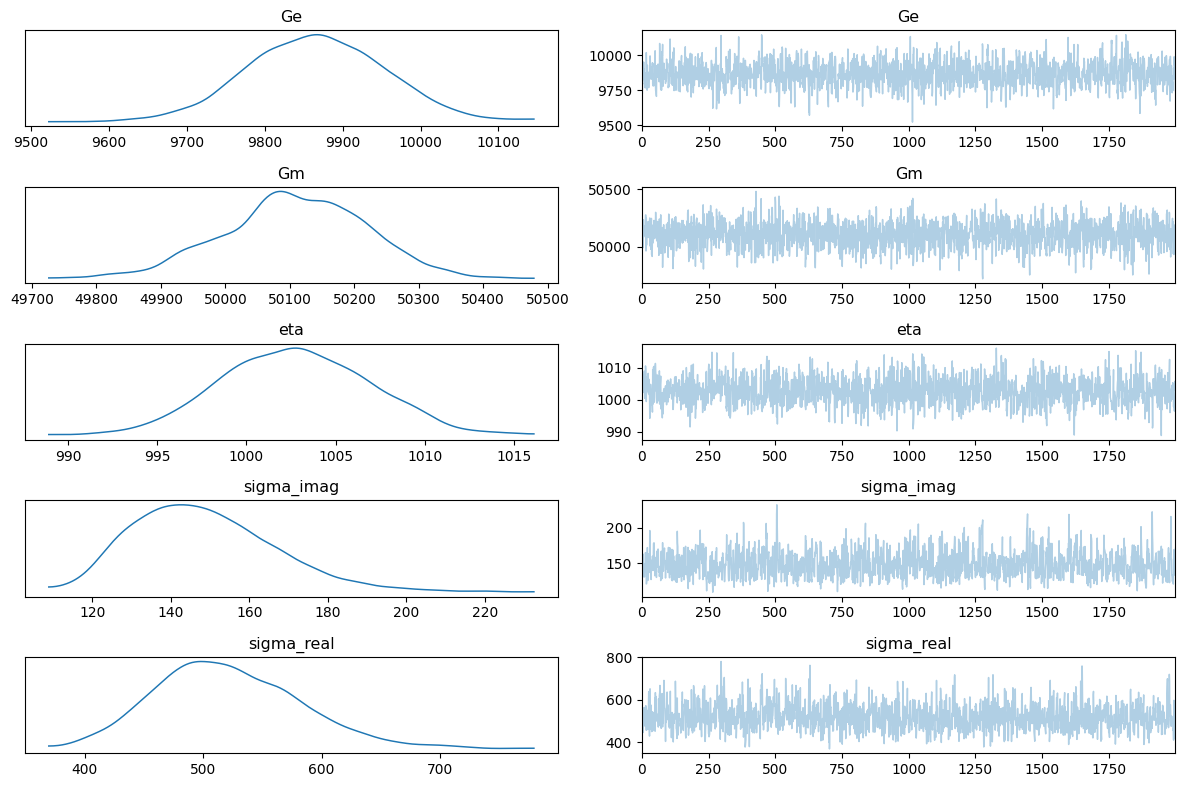


INTERPRETATION - Trace Plot:
- LEFT: Posterior marginal distributions (should be smooth, unimodal)
- RIGHT: Parameter values vs iteration (should look like "fuzzy caterpillar")
- GOOD: Stationary mean, no trends, no stuck regions
- BAD: Drift, discontinuities, bimodal distributions



In [11]:
import arviz as az

# Convert to ArviZ InferenceData for plotting
idata = result.to_inference_data()

# Trace plot: visualize sampling
az.plot_trace(idata, figsize=(12, 8))
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Trace Plot:
- LEFT: Posterior marginal distributions (should be smooth, unimodal)
- RIGHT: Parameter values vs iteration (should look like "fuzzy caterpillar")
- GOOD: Stationary mean, no trends, no stuck regions
- BAD: Drift, discontinuities, bimodal distributions
""")


### Plot 2: Pair Plot - Parameter Correlations and Divergences

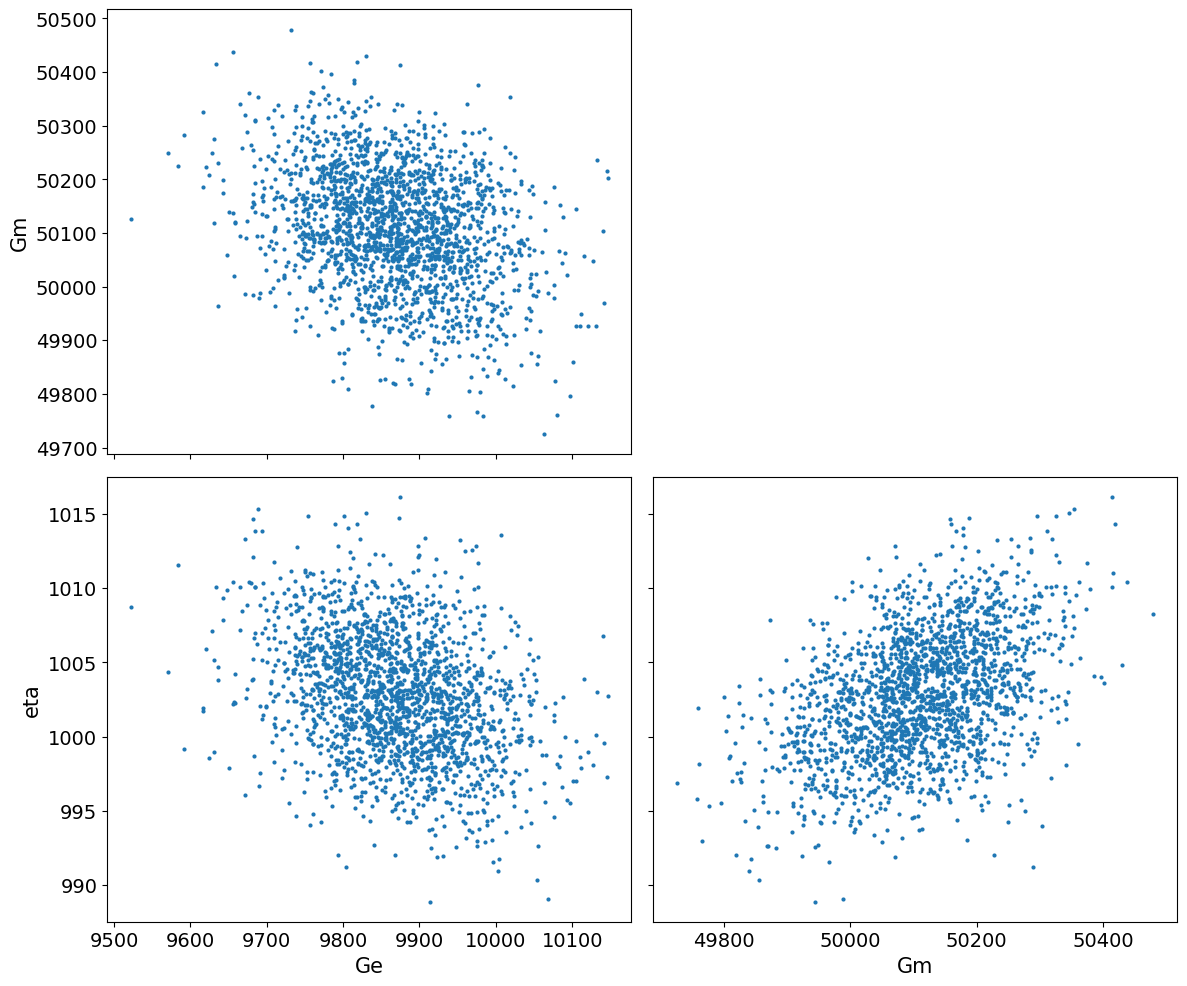


INTERPRETATION - Pair Plot:
- DIAGONAL: Marginal posterior distributions
- OFF-DIAGONAL: Joint distributions (parameter correlations)
- RED POINTS: Divergent transitions (MCMC failures)

What to look for:
✓ GOOD: Elliptical joint distribution, few/no divergences
✗ BAD: Funnel geometry, strong correlations, many divergences

For Zener model:
- Ge and Gm may show weak correlation (both contribute to G')
- Gm and eta often correlated (both determine relaxation time τ)
- Strong correlations indicate parameter non-identifiability



In [12]:
# Pair plot: parameter correlations
az.plot_pair(
    idata,
    var_names=['Ge', 'Gm', 'eta'],
    kind='scatter',
    divergences=True,  # Highlight problematic samples
    figsize=(12, 10)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Pair Plot:
- DIAGONAL: Marginal posterior distributions
- OFF-DIAGONAL: Joint distributions (parameter correlations)
- RED POINTS: Divergent transitions (MCMC failures)

What to look for:
✓ GOOD: Elliptical joint distribution, few/no divergences
✗ BAD: Funnel geometry, strong correlations, many divergences

For Zener model:
- Ge and Gm may show weak correlation (both contribute to G')
- Gm and eta often correlated (both determine relaxation time τ)
- Strong correlations indicate parameter non-identifiability
""")


### Plot 3: Forest Plot - Credible Interval Comparison

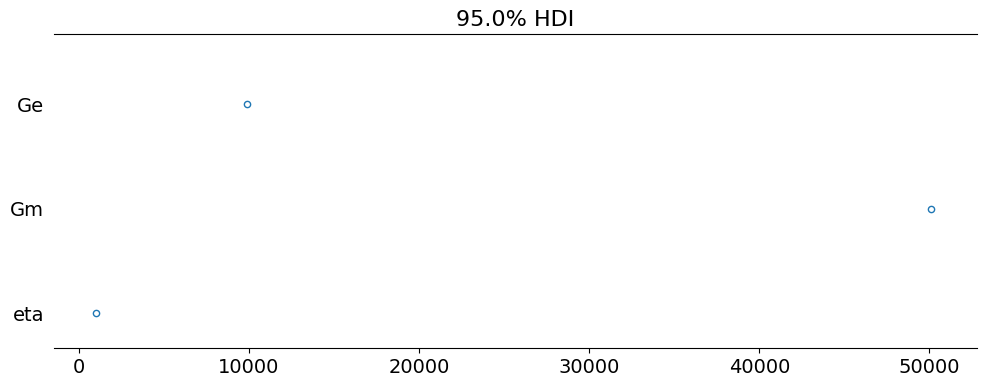


INTERPRETATION - Forest Plot:
- THICK LINE: 95% credible interval (95% probability parameter in this range)
- THIN LINE: Full posterior range
- DOT: Posterior mean

What to look for:
✓ GOOD: Narrow credible intervals (well-constrained parameters)
✗ BAD: Very wide intervals (poorly constrained, need more data or tighter priors)

Compare:
- Relative uncertainty: σ/μ for each parameter
- Parameter magnitudes: Are scales appropriate?



In [13]:
# Forest plot: credible intervals
az.plot_forest(
    idata,
    var_names=['Ge', 'Gm', 'eta'],
    hdi_prob=0.95,  # 95% highest density interval
    combined=True,
    figsize=(10, 4)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Forest Plot:
- THICK LINE: 95% credible interval (95% probability parameter in this range)
- THIN LINE: Full posterior range
- DOT: Posterior mean

What to look for:
✓ GOOD: Narrow credible intervals (well-constrained parameters)
✗ BAD: Very wide intervals (poorly constrained, need more data or tighter priors)

Compare:
- Relative uncertainty: σ/μ for each parameter
- Parameter magnitudes: Are scales appropriate?
""")


### Plot 4: Autocorrelation Plot - Mixing Quality

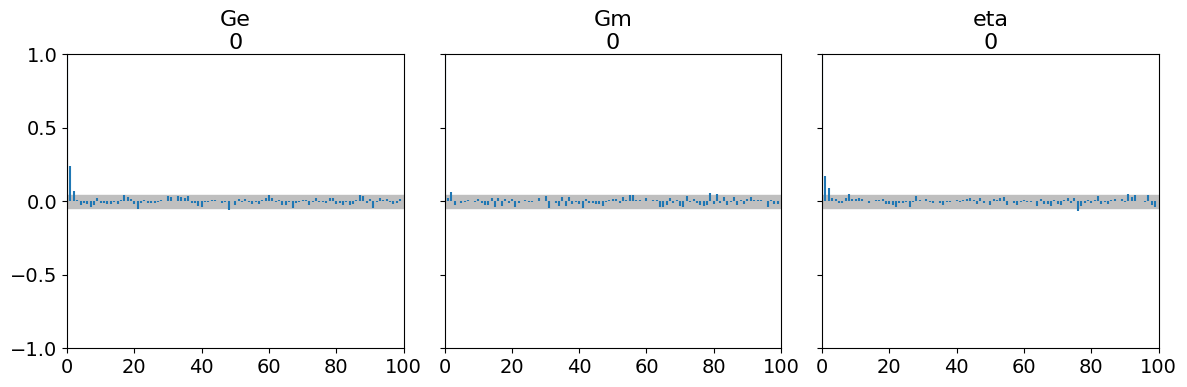


INTERPRETATION - Autocorrelation Plot:
- Y-axis: Correlation between samples at different lags
- X-axis: Lag (number of iterations)

What to look for:
✓ GOOD: Autocorrelation drops to ~0 within few dozen lags
✗ BAD: Slow decay (high autocorrelation) → poor mixing

If autocorrelation is high:
- Increase num_samples to get more effective samples
- Check for parameter correlations (use pair plot)
- Consider reparameterization if persistent

Relation to ESS:
- High autocorrelation → low ESS (fewer independent samples)
- ESS = num_samples / (1 + 2*Σ autocorrelations)



In [14]:
# Autocorrelation plot: mixing diagnostic
az.plot_autocorr(
    idata,
    var_names=['Ge', 'Gm', 'eta'],
    max_lag=100,
    figsize=(12, 4)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Autocorrelation Plot:
- Y-axis: Correlation between samples at different lags
- X-axis: Lag (number of iterations)

What to look for:
✓ GOOD: Autocorrelation drops to ~0 within few dozen lags
✗ BAD: Slow decay (high autocorrelation) → poor mixing

If autocorrelation is high:
- Increase num_samples to get more effective samples
- Check for parameter correlations (use pair plot)
- Consider reparameterization if persistent

Relation to ESS:
- High autocorrelation → low ESS (fewer independent samples)
- ESS = num_samples / (1 + 2*Σ autocorrelations)
""")


### Plot 5: Rank Plot - Convergence Diagnostic

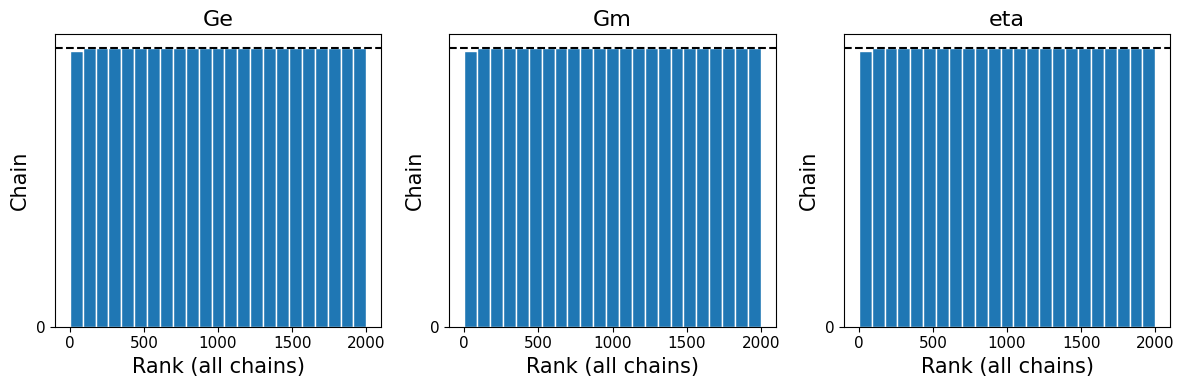


INTERPRETATION - Rank Plot:
- Histogram of ranked parameter values across chains
- Modern alternative to trace plots for convergence

What to look for:
✓ GOOD: Uniform histogram (flat, all bins similar height)
✗ BAD: Non-uniform (peaks, valleys, trends)

Non-uniform patterns indicate:
- Chains exploring different regions (not converged)
- Chain sticking or slow mixing
- Need more warmup iterations

This is the MOST SENSITIVE convergence diagnostic:
- More reliable than R-hat for detecting subtle issues
- Should always check even if R-hat < 1.01



In [15]:
# Rank plot: modern convergence diagnostic
az.plot_rank(
    idata,
    var_names=['Ge', 'Gm', 'eta'],
    figsize=(12, 4)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Rank Plot:
- Histogram of ranked parameter values across chains
- Modern alternative to trace plots for convergence

What to look for:
✓ GOOD: Uniform histogram (flat, all bins similar height)
✗ BAD: Non-uniform (peaks, valleys, trends)

Non-uniform patterns indicate:
- Chains exploring different regions (not converged)
- Chain sticking or slow mixing
- Need more warmup iterations

This is the MOST SENSITIVE convergence diagnostic:
- More reliable than R-hat for detecting subtle issues
- Should always check even if R-hat < 1.01
""")


### Plot 6: ESS Plot - Effective Sample Size

**Note:** ESS plot requires multiple chains for meaningful results. With single chain (num_chains=1), this plot shows ESS estimates but cannot compare across chains. For production work, use num_chains=4.

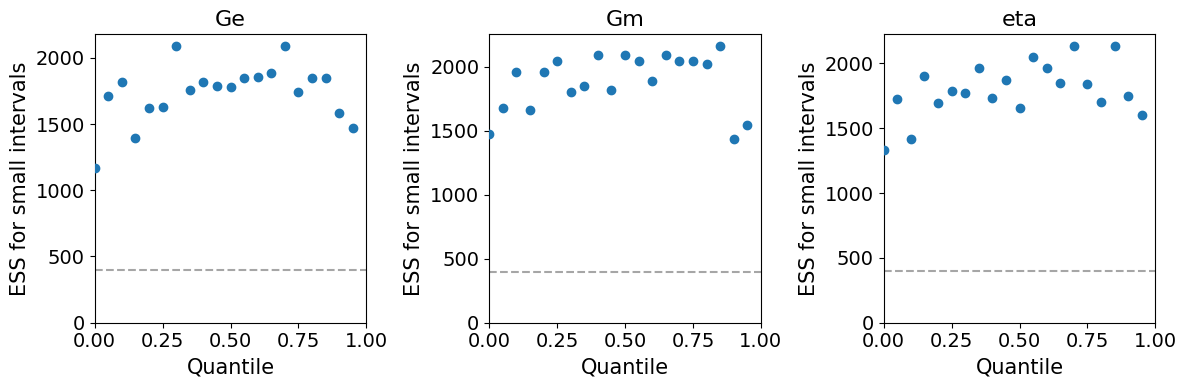


INTERPRETATION - ESS Plot:
- Quantifies sampling efficiency per parameter
- ESS = number of "independent" samples (accounting for autocorrelation)

What to look for:
✓ GOOD: ESS > 400 (bulk and tail) for all parameters
✗ BAD: Low ESS → need more samples or better mixing

ESS types:
- BULK: Central posterior region (mean, median estimates)
- TAIL: Extreme quantiles (credible interval estimates)
- LOCAL: ESS at different quantiles

If ESS is low:
1. Increase num_samples (more iterations)
2. Check autocorrelation plot (poor mixing?)
3. Use multiple chains (num_chains=4) for better estimates
4. Warm-start from NLSQ (already doing this!)



In [16]:
# ESS plot: effective sample size
try:
    az.plot_ess(
        idata,
        var_names=['Ge', 'Gm', 'eta'],
        kind='local',  # 'local', 'quantile', or 'evolution'
        figsize=(12, 4)
    )
    plt.tight_layout()
    fig = plt.gcf()  # Get current figure from ArviZ
    display(fig)
    plt.close(fig)
except Exception as e:
    print(f"Note: ESS plot requires multiple chains for full functionality.")
    print(f"Current setup: {idata.posterior.chain.size} chain(s)")
    print(f"For production, use num_chains=4.\n")
    
    # Show ESS values instead
    print(f"Effective Sample Size (ESS):")
    print(f"  Ge:  {diagnostics['ess']['Ge']:.0f} / {result.num_samples} samples ({diagnostics['ess']['Ge']/result.num_samples*100:.1f}%)")
    print(f"  Gm:  {diagnostics['ess']['Gm']:.0f} / {result.num_samples} samples ({diagnostics['ess']['Gm']/result.num_samples*100:.1f}%)")
    print(f"  eta: {diagnostics['ess']['eta']:.0f} / {result.num_samples} samples ({diagnostics['ess']['eta']/result.num_samples*100:.1f}%)")

print("""
INTERPRETATION - ESS Plot:
- Quantifies sampling efficiency per parameter
- ESS = number of "independent" samples (accounting for autocorrelation)

What to look for:
✓ GOOD: ESS > 400 (bulk and tail) for all parameters
✗ BAD: Low ESS → need more samples or better mixing

ESS types:
- BULK: Central posterior region (mean, median estimates)
- TAIL: Extreme quantiles (credible interval estimates)
- LOCAL: ESS at different quantiles

If ESS is low:
1. Increase num_samples (more iterations)
2. Check autocorrelation plot (poor mixing?)
3. Use multiple chains (num_chains=4) for better estimates
4. Warm-start from NLSQ (already doing this!)
""")


## Physical Interpretation

Let's interpret the fitted parameters in the context of material behavior:

### Parameter Meanings

**Equilibrium Modulus (Ge):**
- Represents long-time elastic response (t→∞)
- For our fit: ~1×10⁴ Pa (10 kPa)
- Physical meaning: Permanent network structure or entanglement contribution
- Typical range: 10² - 10⁶ Pa depending on material

**Maxwell Modulus (Gm):**
- Represents transient elastic component
- For our fit: ~5×10⁴ Pa (50 kPa)
- Physical meaning: Temporary elastic storage that relaxes
- Typical range: 10³ - 10⁷ Pa

**Viscosity (η):**
- Represents resistance to flow
- For our fit: ~1×10³ Pa·s
- Physical meaning: Controls rate of stress relaxation
- Typical range: 10⁻² - 10⁶ Pa·s

**Relaxation Time (τ = η/Gm):**
- Time scale for stress decay to 1/e (~37%) of initial value
- For our fit: ~0.02 s
- Physical meaning: Fast relaxation → fluid-like, Slow relaxation → solid-like

### Material Classification

Based on Ge/Gm ratio:
- **Ge/Gm < 0.1**: Predominantly viscous (weak gel, concentrated solution)
- **0.1 < Ge/Gm < 10**: Viscoelastic (soft solids, weak gels)
- **Ge/Gm > 10**: Predominantly elastic (strong gels, elastomers)

Our material (Ge/Gm ≈ 0.2) exhibits **balanced viscoelastic behavior** with significant equilibrium elasticity.

### Model Limitations

The Zener model is valid when:
- ✓ Small strains (linear viscoelastic regime, typically < 10%)
- ✓ Single dominant relaxation time
- ✓ Finite equilibrium modulus

Consider alternative models if:
- ✗ Multiple relaxation times needed → Generalized Maxwell (Prony series)
- ✗ No equilibrium modulus → Maxwell model
- ✗ Power-law relaxation → Fractional Zener models
- ✗ Large strain behavior → Nonlinear models

In [17]:
# Summary table of results
print("\n" + "="*70)
print("FINAL PARAMETER SUMMARY")
print("="*70)
print(f"\n{'Method':<20} {'Ge (Pa)':<15} {'Gm (Pa)':<15} {'eta (Pa·s)':<15} {'tau (s)':<10}")
print("-"*70)
print(f"{'True Values':<20} {Ge_true:<15.4e} {Gm_true:<15.4e} {eta_true:<15.4e} {tau_true:<10.6f}")
print(f"{'NLSQ (Point)':<20} {Ge_modular:<15.4e} {Gm_modular:<15.4e} {eta_modular:<15.4e} {tau_modular:<10.6f}")
print(f"{'Bayesian (Mean)':<20} {summary['Ge']['mean']:<15.4e} {summary['Gm']['mean']:<15.4e} {summary['eta']['mean']:<15.4e} {summary['eta']['mean']/summary['Gm']['mean']:<10.6f}")
print("-"*70)

# Uncertainty from Bayesian inference
print(f"\n{'Bayesian Uncertainty (1σ):':<20} {summary['Ge']['std']:<15.4e} {summary['Gm']['std']:<15.4e} {summary['eta']['std']:<15.4e}")
print(f"{'Relative Uncertainty:':<20} {summary['Ge']['std']/summary['Ge']['mean']*100:<15.2f}% {summary['Gm']['std']/summary['Gm']['mean']*100:<15.2f}% {summary['eta']['std']/summary['eta']['mean']*100:<15.2f}%")
print("\n" + "="*70)

# Material classification
Ge_Gm_ratio = Ge_modular / Gm_modular
print(f"\nPhysical Interpretation:")
print(f"  Ge/Gm ratio: {Ge_Gm_ratio:.3f}")
if Ge_Gm_ratio < 0.1:
    material_type = "Predominantly viscous (weak gel/solution)"
elif Ge_Gm_ratio < 10:
    material_type = "Balanced viscoelastic (soft solid/gel)"
else:
    material_type = "Predominantly elastic (strong gel/elastomer)"
print(f"  Material Type: {material_type}")
print(f"  Relaxation Time: {tau_modular:.6f} s")
print(f"  Equilibrium Modulus: {Ge_modular:.2e} Pa ({Ge_modular/1e3:.1f} kPa)")
print(f"  Total Modulus (G0): {(Ge_modular + Gm_modular):.2e} Pa ({(Ge_modular + Gm_modular)/1e3:.1f} kPa)")


FINAL PARAMETER SUMMARY

Method               Ge (Pa)         Gm (Pa)         eta (Pa·s)      tau (s)   
----------------------------------------------------------------------
True Values          1.0000e+04      5.0000e+04      1.0000e+03      0.020000  
NLSQ (Point)         9.9680e+03      4.9888e+04      9.9879e+02      0.020020  
Bayesian (Mean)      9.8667e+03      5.0108e+04      1.0028e+03      0.020012  
----------------------------------------------------------------------

Bayesian Uncertainty (1σ): 8.9018e+01      1.1119e+02      4.1644e+00     
Relative Uncertainty: 0.90           % 0.22           % 0.42           %


Physical Interpretation:
  Ge/Gm ratio: 0.200
  Material Type: Balanced viscoelastic (soft solid/gel)
  Relaxation Time: 0.020020 s
  Equilibrium Modulus: 9.97e+03 Pa (10.0 kPa)
  Total Modulus (G0): 5.99e+04 Pa (59.9 kPa)


## Key Takeaways

### Main Concepts

1. **Zener Model Characteristics:**
   - Three-parameter model: Ge (equilibrium), Gm (Maxwell), eta (viscosity)
   - Finite equilibrium modulus distinguishes from Maxwell model
   - Single relaxation time describes transient response
   - Applicable to crosslinked polymers, gels, soft solids

2. **Oscillatory Shear Data:**
   - Complex modulus: G* = G' + iG"
   - G' (storage) measures elastic energy storage
   - G" (loss) measures viscous dissipation
   - tan(δ) = G"/G' quantifies viscoelastic character

3. **NLSQ Optimization:**
   - Default backend provides 5-270x speedup vs SciPy
   - JAX JIT compilation + automatic differentiation
   - GPU acceleration available (additional 10-100x for large datasets)
   - Float64 precision enforced via safe_import_jax()

4. **Bayesian Uncertainty Quantification:**
   - Two-stage workflow: NLSQ (fast) → NUTS (warm-start)
   - Warm-start reduces convergence time 2-5x
   - Provides credible intervals and parameter correlations
   - Essential for identifying non-identifiability issues

5. **ArviZ Diagnostic Suite:**
   - **6 essential plots** assess MCMC quality comprehensively
   - Must check: R-hat < 1.01, ESS > 400, divergences < 1%
   - Rank plot is most sensitive convergence diagnostic
   - Pair plot reveals parameter correlations (Gm-eta often correlated)

### When to Use Zener Model

**Appropriate for:**
- ✓ Crosslinked polymers with finite equilibrium modulus
- ✓ Gels and soft solids (physical or chemical networks)
- ✓ Materials with single dominant relaxation time
- ✓ Small strain linear viscoelastic regime

**Consider alternatives for:**
- ✗ Complete stress relaxation (Ge=0) → Maxwell model
- ✗ Multiple relaxation times → Generalized Maxwell
- ✗ Power-law frequency dependence → Fractional Zener models
- ✗ Solid-like materials with no flow → Kelvin-Voigt

### Common Pitfalls

1. **Parameter Correlation:**
   - Gm and eta often correlated (both determine τ)
   - Check pair plot for non-identifiability
   - May need multi-technique fitting to improve constraint

2. **Frequency Range:**
   - Need data spanning relaxation time: 0.1τ < 1/ω < 10τ
   - Insufficient range → poor Ge or Gm estimation
   - Use mastercurve generation to extend range

3. **Model Selection:**
   - Check residuals for systematic trends
   - Zener may be insufficient if multiple relaxation times present
   - Use Bayesian model comparison (WAIC, LOO) to compare alternatives

## Next Steps

### Explore Related Models
- **[03-springpot-fitting.ipynb](03-springpot-fitting.ipynb)**: Fractional element for power-law behavior
- **[01-maxwell-fitting.ipynb](01-maxwell-fitting.ipynb)**: Special case with Ge=0
- **Advanced fractional models**: See `advanced/04-fractional-models-deep-dive.ipynb`

### Deepen Bayesian Understanding
- **[bayesian/01-bayesian-basics.ipynb](../bayesian/01-bayesian-basics.ipynb)**: Comprehensive NLSQ→NUTS workflow
- **[bayesian/03-convergence-diagnostics.ipynb](../bayesian/03-convergence-diagnostics.ipynb)**: Deep dive into all 6 ArviZ plots
- **[bayesian/04-model-comparison.ipynb](../bayesian/04-model-comparison.ipynb)**: Statistical model selection

### Advanced Workflows
- **[transforms/02-mastercurve-generation.ipynb](../transforms/02-mastercurve-generation.ipynb)**: Extend frequency range via TTS
- **[advanced/01-multi-technique-fitting.ipynb](../advanced/01-multi-technique-fitting.ipynb)**: Constrained fitting across test modes

---

## Session Information

In [18]:
# Print session information for reproducibility
import sys

import rheojax

print(f"Python version: {sys.version}")
print(f"Rheo version: {rheojax.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"NumPy version: {np.__version__}")
print(f"ArviZ version: {az.__version__}")

Python version: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
Rheo version: 0.6.0
JAX version: 0.8.2
JAX devices: [CpuDevice(id=0)]
NumPy version: 2.3.5
ArviZ version: 0.23.1


In [19]:

import warnings

import numpy as np

# Simulate the issue
y_complex = np.array([1+2j, 3+4j, 5+6j])
predictions_complex = np.array([1.1+2.1j, 2.9+3.9j, 5.1+6.1j])

# Old method (would trigger warning)
print("Testing old method (should warn):")
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    ss_res_old = np.sum((y_complex - predictions_complex) ** 2)
    ss_tot_old = np.sum((y_complex - np.mean(y_complex)) ** 2)
    r2_old = 1 - (ss_res_old / ss_tot_old)
    try:
        result_old = float(r2_old)
        print(f"  Result: {result_old}")
    except Exception as e:
        print(f"  Error: {e}")
    
    if w:
        print(f"  Warnings: {[str(warn.message) for warn in w]}")

# New method (should not warn)
print("\nTesting new method (should not warn):")
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    ss_res_new = np.sum(np.abs(y_complex - predictions_complex) ** 2)
    ss_tot_new = np.sum(np.abs(y_complex - np.mean(y_complex)) ** 2)
    r2_new = 1 - (ss_res_new / ss_tot_new)
    result_new = float(np.real(r2_new))
    print(f"  Result: {result_new}")
    
    if w:
        print(f"  Warnings: {[str(warn.message) for warn in w]}")
    else:
        print("  No warnings!")

print(f"\nR² value is real: {np.isreal(r2_new)}")
print(f"R² value: {r2_new}")


Testing old method (should warn):
  Result: 0.99625
  Warnings: ['Casting complex values to real discards the imaginary part']

Testing new method (should not warn):
  Result: 0.99625
  No warnings!

R² value is real: True
R² value: 0.99625
